# Movie Review Analysis

This notebook demonstrates advanced text preprocessing techniques for sentiment analysis on movie reviews.

## Preprocessing Steps

- Lowercasing
- Removing HTML tags and URLs
- Removing punctuation
- Removing digits
- Vocabulary correction
- Stopword removal
- Tokenization
- Lemmatization

Some steps are implemented with parallel processing for faster execution. Progress for all operations is visualized using `tqdm`.

The following Python libraries are used throughout this notebook:
- `bs4`
- `nltk`
- `spacy`
- `SymSpell`

**Dataset:**  
The dataset used is ["IMDB Dataset of 50K Movie Reviews"](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) by lakshmi25npathi, which contains 50,000 labeled movie reviews for binary sentiment classification.

---

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import kagglehub
import numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup
from multiprocessing import Pool, cpu_count
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from functools import partial
import re
from kagglehub import KaggleDatasetAdapter

In [61]:
pip install symspellpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 kB 5.9 MB/s eta 0:00:00


In [30]:
#Data set is provided from kaggle
file_path = "IMDB Dataset.csv"

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
  file_path,
)

/tmp/ipython-input-30-1871077123.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  data = kagglehub.load_dataset(


In [42]:
df = data.copy()

In [43]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


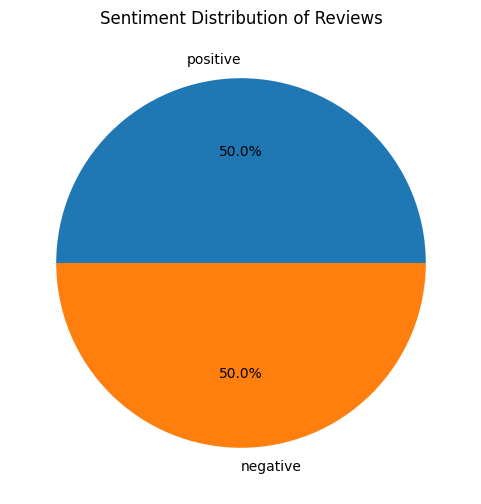

In [9]:
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Distribution of Reviews')
plt.show()

# Text Preprocessing

## Lowercasing

In [44]:
df["review"] = df["review"].str.lower()

In [45]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


 ## Removing HTML Tags and URLs

In [53]:
def remove_html_tags(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [47]:
df['review'] = df['review'].apply(remove_html_tags)

In [48]:
def remove_urls(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

In [49]:
df['review'] = df['review'].apply(remove_urls)

## Removing Punctuation

In [50]:
def remove_punctuation(text):
    # string.punctuation include all of the punctuations
    return text.translate(str.maketrans('', '', string.punctuation))

In [51]:
df['review'] = df['review'].apply(remove_punctuation)

In [52]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


## Removing Digits

In [54]:
def remove_digits(text):
    return text.translate(str.maketrans('', '', string.digits))

In [55]:
df['review'] = df['review'].apply(remove_digits)

## Vocab Correcting
This part takes too much time, so I used SymSpell and parallel processing.

In [66]:
import urllib.request

In [67]:
#Downloading necessary document for SymSpell
urllib.request.urlretrieve(
    "https://github.com/mammothb/symspellpy/raw/master/symspellpy/frequency_dictionary_en_82_765.txt",
    "frequency_dictionary.txt"
)

('frequency_dictionary.txt', <http.client.HTTPMessage at 0x7c385c5cea50>)

In [74]:
from symspellpy import SymSpell
global_sym_spell = None

In [75]:
def init_worker():
    global global_sym_spell
    global_sym_spell = SymSpell(max_dictionary_edit_distance=2)
    global_sym_spell.load_dictionary("frequency_dictionary.txt", term_index=0, count_index=1)

In [76]:
def correct_single(text):
    result = global_sym_spell.lookup_compound(text, max_edit_distance=2)
    return result[0].term if result else text

In [78]:
def correct_batch_parallel(texts, n_workers=None):
    n_workers = n_workers or cpu_count()

    with Pool(processes=n_workers, initializer=init_worker) as pool:
        # Parallel processing + tqdm
        results = list(tqdm(
            pool.imap(correct_single, texts, chunksize=100),
            total=len(texts),
            desc = f"Parallel Correcting ({n_workers} cores)",
            unit="row"
        ))
    return results

In [79]:
df["review"] = correct_batch_parallel(df["review"].tolist())

Parallel Correcting (8 cores): 100%|██████████| 50000/50000 [07:54<00:00, 105.39row/s]


In [80]:
corrected_df = df.copy()

## Stopwords

In [90]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [83]:
global_stopwords = None

In [85]:
def stopwords_worker():
    global global_stopwords
    global_stopwords = set(stopwords.words('english'))

def remove_stops_single(text):
    words = word_tokenize(text.lower())
    return ' '.join([word for word in words if word not in global_stopwords])

def remove_stopwords_parallel(texts, n_workers=None):
    n_workers = n_workers or cpu_count()

    with Pool(processes=n_workers, initializer=stopwords_worker) as pool:
        results = list(tqdm(
            pool.imap(remove_stops_single, texts, chunksize=100),
            total=len(texts),
            desc=f"Parallel Stopwords ({n_workers} core)",
            unit="row"
        ))

    return results

In [91]:
corrected_df['review'] = remove_stopwords_parallel(corrected_df['review'].tolist())

Parallel Stopwords (8 core): 100%|██████████| 50000/50000 [00:09<00:00, 5235.36row/s]


In [93]:
corrected_df

,review,sentiment
0,one reviewers mentioned watching episode 'll h...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake thinks zombie...,negative
4,petter matters love time money visually stunni...,positive
...,...,...
49995,thought movie right good job want creative ori...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,catholic taught parochial elementary schools n...,negative
49998,going disagree previous comment side martin on...,negative


## Tokenization

In [95]:
corrected_df['tokens'] = [word_tokenize(text) for text in tqdm(corrected_df['review'], desc="Tokenizing")]

Tokenizing: 100%|██████████| 50000/50000 [00:23<00:00, 2146.26it/s]


In [96]:
corrected_df

,review,sentiment,tokens
0,one reviewers mentioned watching episode 'll h...,positive,"[one, reviewers, mentioned, watching, episode,..."
1,wonderful little production filming technique ...,positive,"[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,basically family little boy jake thinks zombie...,negative,"[basically, family, little, boy, jake, thinks,..."
4,petter matters love time money visually stunni...,positive,"[petter, matters, love, time, money, visually,..."
...,...,...,...
49995,thought movie right good job want creative ori...,positive,"[thought, movie, right, good, job, want, creat..."
49996,bad plot bad dialogue bad acting idiotic direc...,negative,"[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,catholic taught parochial elementary schools n...,negative,"[catholic, taught, parochial, elementary, scho..."
49998,going disagree previous comment side martin on...,negative,"[going, disagree, previous, comment, side, mar..."


## Lemmatization

In [92]:
import spacy

In [110]:
def init_process():
    global nlp
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def lemmatize_tokens(tokens):
    try:
        doc = spacy.tokens.Doc(nlp.vocab, words=tokens)
        for _, proc in nlp.pipeline:
            proc(doc)
        return [token.lemma_ for token in doc]
    except:
        return tokens

def parallel_lemmatize(df, column='tokens', workers=None):
    workers = workers or cpu_count()
    data_split = np.array_split(df[column], workers)

    with Pool(workers, initializer=init_process) as pool:
        results = []
        for res in tqdm(
            pool.imap(partial(process_chunk), data_split),
            total=workers,
            desc="Main Processes"
        ):
            results.extend(res)
    return results

def process_chunk(chunk):
    return [lemmatize_tokens(tokens) for tokens in tqdm(chunk, desc="Sub Processes", leave=False)]


In [111]:
corrected_df['lemmas'] = parallel_lemmatize(corrected_df)

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
Main Processes: 100%|██████████| 8/8 [02:03<00:00, 15.38s/it]


In [112]:
corrected_df

,review,sentiment,tokens,lemmas
0,one reviewers mentioned watching episode 'll h...,positive,"[one, reviewers, mentioned, watching, episode,...","[one, reviewer, mention, watch, episode, will,..."
1,wonderful little production filming technique ...,positive,"[wonderful, little, production, filming, techn...","[wonderful, little, production, filming, techn..."
2,thought wonderful way spend time hot summer we...,positive,"[thought, wonderful, way, spend, time, hot, su...","[think, wonderful, way, spend, time, hot, summ..."
3,basically family little boy jake thinks zombie...,negative,"[basically, family, little, boy, jake, thinks,...","[basically, family, little, boy, jake, think, ..."
4,petter matters love time money visually stunni...,positive,"[petter, matters, love, time, money, visually,...","[petter, matter, love, time, money, visually, ..."
...,...,...,...,...
49995,thought movie right good job want creative ori...,positive,"[thought, movie, right, good, job, want, creat...","[thought, movie, right, good, job, want, creat..."
49996,bad plot bad dialogue bad acting idiotic direc...,negative,"[bad, plot, bad, dialogue, bad, acting, idioti...","[bad, plot, bad, dialogue, bad, acting, idioti..."
49997,catholic taught parochial elementary schools n...,negative,"[catholic, taught, parochial, elementary, scho...","[catholic, teach, parochial, elementary, schoo..."
49998,going disagree previous comment side martin on...,negative,"[going, disagree, previous, comment, side, mar...","[go, disagree, previous, comment, side, martin..."


## To CSV

In [113]:
corrected_df.to_csv("movie_review_cleaned.csv",index=False)